# Where to open a new coffee shop?

## 📖 Background
You are helping a client who owns coffee shops in Colorado. The company's coffee shops serve high-quality and responsibly sourced coffee,  pastries, and sandwiches. They operate three locations in Fort Collins and want to expand into Denver. 

Your client believes that the ideal location for a new store is close to affluent households, and the store appeals to the 20-35 year old demographic.
 
Your team collected geographical and demographic information about Denver's neighborhoods to assist the search. They also collected data for Starbucks stores in Denver. Starbucks and the new coffee shops do not compete for the same clients; the team included their location as a reference.

## 💪 Challenge
Provide your client a list of neighborhoods in Denver where they should consider expanding. Include:
* A visualization of Denver's neighborhoods and the Starbucks store locations.
* Find the neighborhoods with the highest proportion of people in the target demographic.
* Select the top three neighborhoods where your client should focus their search.

# Key insights : 

* The population that interests us (young and affluent) is very present in the city center.

<br/>

* So are the Starbucks stores.

<br/>

* The three neighborhoods in which the client should expand their business, based on the latter's criteria, are the North Capitol Hill , Five Points , and Gateway - Green Valley Ranch neighborhoods.

# Import libraries and load data :

In [1]:
import pandas as pd 
import geopandas as gpd 
from shapely.geometry import Point 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import warnings

In [2]:
# Drop the warnings 
warnings.filterwarnings("ignore")

In [3]:
neighborhoods = gpd.read_file('C:\\Users\\lucas\\OneDrive\\Bureau\\Code\\Python\\DATACAMP\\Projets\\Geopandas\\neighborhoods.shx')
neighborhoods.head(1)

,NBHD_ID,NBHD_NAME,geometry
0,2,Auraria,"POLYGON ((-105.00042 39.74552, -105.00041 39.7..."


In [4]:
census = pd.read_csv('C:\\Users\\lucas\\OneDrive\\Bureau\\Code\\Python\\DATACAMP\\Projets\\Geopandas\\census.csv')
census.head(1)

,NBHD_ID,NBHD_NAME,POPULATION_2010,AGE_LESS_18,AGE_18_TO_34,AGE_35_TO_65,AGE_65_PLUS,NUM_HOUSEHOLDS,FAMILIES,NUM_HHLD_100K+
0,1,Athmar Park,8898.0,2649.0,2406.0,3112.0,731.0,2781.0,1964.0,425.0


In [5]:
denver = pd.read_csv('C:\\Users\\lucas\\OneDrive\\Bureau\\Code\\Python\\DATACAMP\\Projets\\Geopandas\\denver.csv')
denver.head(1)

,StoreNumber,Name,PhoneNumber,Street1,Street2,Street3,PostalCode,Longitude,Latitude
0,27708-240564,Auraria Tivoli - Student Union,3035563700,900 Auraria Parkway,NaN,NaN,80204,-105.01,39.75


# Preprocessing : 

<br/>

The census and neighborhoods can already be combined into a single GeoDataFrame. Also , we can see that the denver DataFrame contains latitude and longitude coordinates. To be actionable, these coordinates must be transformed into shapely points.

In [6]:
# Create a geodataframe with the census data and the neihboorhood geometry
neigh_census = gpd.GeoDataFrame(census , geometry=neighborhoods.geometry , crs =neighborhoods.crs)

# Transform coordinates into shapely points
denver['geometry'] = denver.apply(lambda x : Point(float(x.Longitude) , float(x.Latitude)) , axis=1)

print(neigh_census.crs)

None


Our data does not contain a Coordinates Reference System (CRS). 
It is possible to work without CRS. But in order to have units of measurement understandable for the majority of people , like meters , it is necessary to define a CRS manually.

In [7]:
# Get the area in meters
neigh_census.crs = 'EPSG:4326'
neigh_census= neigh_census.to_crs("+proj=cea units=m")
neigh_census['area_meters'] = np.round((neigh_census.area / 10**6) * 1000 , 2)
neigh_census.to_crs(epsg=4326 , inplace=True)

In order to have a fair idea of ​​the density of the target population, which is the 20-35 year olds, I will create a choropleth with the number of 18 - 34 year olds per square meter.

In [8]:
# Number of people per squared meter
neigh_census['target_per_s_meter'] = neigh_census['AGE_18_TO_34'] / neigh_census['area_meters']
neigh_census = neigh_census.sort_values(by=['target_per_s_meter'] , ascending=False)
neigh_census.reset_index(drop=True , inplace=True)

The second parameter to take into account is the number of wealthy households per neighborhood and per square meter. Indeed, the client mentioned that the ideal location for a new establishment is near wealthy households.

In [9]:
# Number of wealthy household (income above 100 thousand USD per year) per squared meter
neigh_census['rich_hhld_meters'] = neigh_census['NUM_HHLD_100K+'] / neigh_census['area_meters']

# Get the quantiles of interest
quantile_50 = float(neigh_census.dropna()['rich_hhld_meters'].quantile([0.50]))
quantile_75 = float(neigh_census.dropna()['rich_hhld_meters'].quantile([0.75]))

# Create different marker categories
markers = []
for cash in neigh_census['rich_hhld_meters']:
    if cash < quantile_50:
        markers.append('')
    elif quantile_50 <= cash < quantile_75:
        markers.append('rich')   
    elif cash >= quantile_75:
        markers.append('very_rich')
    else:
        markers.append('')

# Add a marker column
neigh_census['markers'] = markers

# Get the centroids 
center_rich = neigh_census[neigh_census['markers'] == 'rich'].centroid
center_very_rich = neigh_census[neigh_census['markers'] == 'very_rich'].centroid

# Visualisation : 

<br/>
The next step will be to visualize our data. Each starbuck location will be marked with a green dot, the neighborhoods with the most wealthy households per square meter will be marked with a dollar sign (two for the ten percent containing the most).

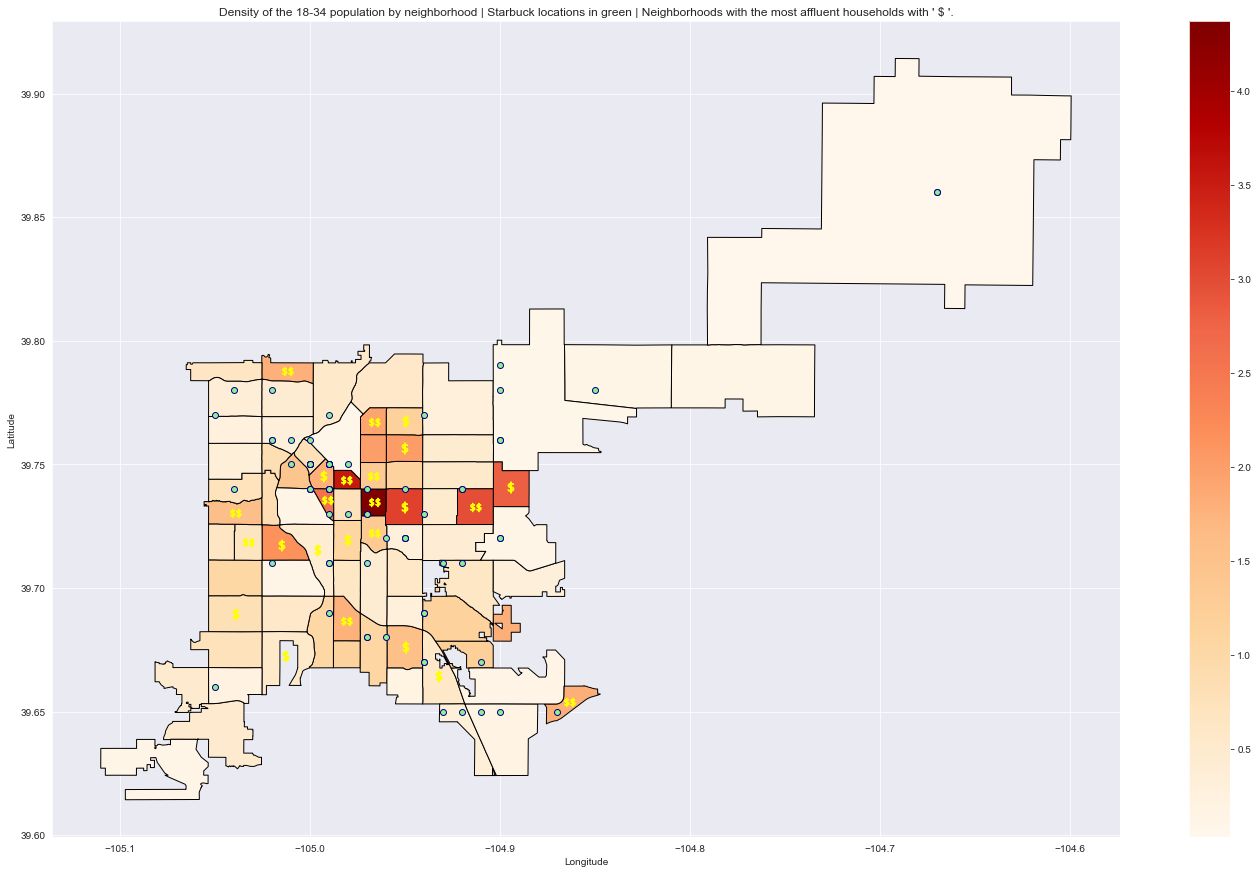

In [10]:
# Create a GeoDataFrame with the starbucks points 
geo_denver = gpd.GeoDataFrame(denver , geometry=denver.geometry , crs=neigh_census.crs)

# ... Within the neighborhoods
geo_starbuck = gpd.sjoin(geo_denver , neigh_census , predicate='within')

# Style matters
sns.set_style('darkgrid')

# Plot
ax = neigh_census.plot(column='target_per_s_meter' , cmap='OrRd' , edgecolor='black' , legend=True , figsize=(25,15))
geo_starbuck.plot(ax=ax , color='lightgreen' , edgecolor='darkblue')
center_rich.plot(ax=ax , marker='$\$$' , color='yellow' , markersize=125)
center_very_rich.plot(ax=ax , marker='$\$\$$' , color='yellow' , markersize=130)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Density of the 18-34 population by neighborhood | Starbuck locations in green | Neighborhoods with the most affluent households with ' $ '.")
plt.show()


We can see, based on this visualization, that three quarters stand out and tick all the boxes. These neighborhoods, although small, have the highest density of young people and are among the ten percent containing the most wealthy households per meter ; their names are Five Points , North Capitol Hill , and Gateway - Green Valley Ranch. Let's visualize their shapes, so that we can more easily identify them on the map.

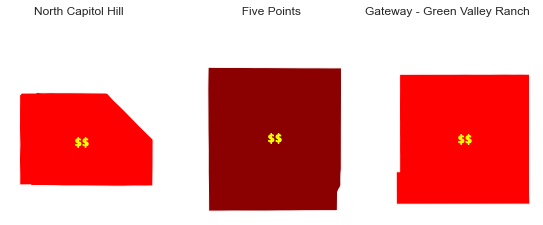

In [11]:
# Subset the points
five_point = neigh_census[neigh_census['NBHD_NAME'] == 'Five Points']
North_capitol = neigh_census[neigh_census['NBHD_NAME'] == 'North Capitol Hill']
Gateway = neigh_census[neigh_census['NBHD_NAME'] == 'Gateway - Green Valley Ranch']
name = ['North Capitol Hill' , 'Five Points' , 'Gateway - Green Valley Ranch']
color = ['red' , 'darkred' , 'red']

# Subset the centroids
five_point_center = five_point.centroid
North_capitol_center = North_capitol.centroid
Gateway_center = Gateway.centroid

# Create a list for both
points = [North_capitol ,  five_point   , Gateway]
centers = [North_capitol_center  , five_point_center , Gateway_center]

# Plot
fig, ax = plt.subplots(1 , 3, figsize=(8 , 4))
fig.tight_layout()
for i in range(3):
    axs = points[i].plot(ax=ax[i] , color=color[i])
    centers[i].plot(ax=axs , marker='$\$\$$' , markersize=180 , color='yellow')
    axs.set_axis_off()

fig.suptitle(f'        {name[0]}                                   {name[1]}                   {name[2]}')
plt.show()

try:
    print(4)

except